# [Twinning field](https://doi.org/10.1103/PhysRevLett.127.113201) via quadratic optimization: Matching unitray evolution operator

In [1]:
using LinearAlgebra
using PyPlot
using DynamicPolynomials
using JuMP
using NLopt

In [2]:
# Pauli matrices
σx = [0 1
    1 0.]

σy = [0 -im
    im 0.]

σz = [1 0
    0 -1.];

##  System 1

In [3]:
# dimensionality of the system
N = 2

# The drift hamiltonian
H₀₁ = σz

# the control Hamiltonian
V₁ = σx

# time
ω₀ = 2.
times = range(0, 2 * 2 * π / ω₀, 500)
Δt = times[2] - times[1]

0.012591553721802777

##  System 2

In [4]:
# The drift hamiltonian  
H₀₂ = σy #[1 0
       #0 -2.]

# the control Hamiltonian
V₂ = [0 0.9
    0.9 0.1]

2×2 Matrix{Float64}:
 0.0  0.9
 0.9  0.1

## Twinning field: to be applied to both the systems

### Harmonic

In [5]:
# Twinning field 
function E(t, X)
    n = length(X)
    @assert n % 2 == 0
    
    k = n ÷ 2
    
    # Note using frequencies lower than ω₀, i.e., we want to get the superoscillating control
    Ω = (1:k) * (ω₀ / (k))
    
    # Using http://dlmf.nist.gov/4.21.E1_5 to parametrize the phase and amplitude
    return sum(
        a * cos(ω * t) + b * sin(ω * t) for (a, b, ω) in zip(X[1:k], X[(k + 1):end], Ω)
    ) 
end

E (generic function with 1 method)

### Polynomial

## Utilities for working with Polynomials

In [6]:
function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end
        
function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)#  LN_BOBYQA

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

## Generate the objective functions to find the controls
 
The idea is to find the twinning field $E(t)$ such that

$$U_1(t + \Delta t, t) \to U_2(t + \Delta t, t), \quad \forall t.$$

where $\| A \|_F^2 = Tr(A A^{\dagger})$.

$$
    U_{1,2}(\Delta t (k + 1), \Delta t k) = T \exp\left[ -i \int_{\Delta t k}^{\Delta t (k + 1)} H_{1,2}(\tau)d\tau\right]
$$
$$
    = \exp\left[ -i \Delta t  H_{1,2}(k\Delta t  + \Delta t / 2)\right] + O(\Delta t^3).
$$

Recall
$$
    e^{-iG} = \frac{e^{-iG/2}}{e^{iG/2}} = \frac{1 - iG/2}{1 + iG/2} + O(G^3)
$$

If $G^\dagger = G$ then $\frac{1 - iG/2}{1 + iG/2}$ is unitary. This is known as the Cayley transform. Hence,

$$
    U_{1,2}(\Delta t (k + 1), \Delta t k) = \frac{1 - i(\Delta t / 2)  H_{1,2}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{1,2}(k\Delta t  + \Delta t / 2)} + O(\Delta t^3).
$$

Since we want

$$
    U_{1}(\Delta t (k + 1), \Delta t k) \to U_{1}(\Delta t (k + 1), \Delta t k),
$$

then we consider the approximation
$$
    \frac{1 - i(\Delta t / 2)  H_{1}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{1}(k\Delta t  + \Delta t / 2)} + O(\Delta t^3)
    \to
    \frac{1 - i(\Delta t / 2)  H_{2}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{2}(k\Delta t  + \Delta t / 2)} + O(\Delta t^3)
$$

$$
   1 - i(\Delta t / 2)  H_{1}(k\Delta t  + \Delta t / 2)
   \to
   \Big[ 1 + i(\Delta t/2)  H_{1}(k\Delta t  + \Delta t / 2) \Big] \frac{1 - i(\Delta t / 2)  H_{2}(k\Delta t  + \Delta t / 2)}{1 + i(\Delta t/2)  H_{2}(k\Delta t  + \Delta t / 2)} 
$$

$$
   \Big[1 - i(\Delta t / 2)  H_{1}(k\Delta t  + \Delta t / 2)\Big]
   \Big[ 1 + i(\Delta t/2)  H_{2}(k\Delta t  + \Delta t / 2) \Big]
   \to
   \Big[ 1 + i(\Delta t/2)  H_{1}(k\Delta t  + \Delta t / 2) \Big] \Big[1 - i(\Delta t / 2)  H_{2}(k\Delta t  + \Delta t / 2)\Big]
$$

Hence, we use the following cost function (objective function)

$$
   O = \sum_{k=0} \left\| 
           \Big[1 - i(\Delta t / 2)  H_{1}(k\Delta t  + \Delta t / 2)\Big]
           \Big[ 1 + i(\Delta t/2)  H_{2}(k\Delta t  + \Delta t / 2) \Big]
           -
           \Big[ 1 + i(\Delta t/2)  H_{1}(k\Delta t  + \Delta t / 2) \Big]
           \Big[1 - i(\Delta t / 2)  H_{2}(k\Delta t  + \Delta t / 2)\Big]
   \right\|_F^2 \to \min.
$$




In [7]:
@polyvar X[1:8]

(PolyVar{true}[X₁, X₂, X₃, X₄, X₅, X₆, X₇, X₈],)

In [8]:
H₁(t, X) = H₀₁ + V₁ * E(t, X)
H₂(t, X) = H₀₂ + V₂ * E(t, X)

obj = sum(
    square_frobenius_norm(
        (I - im * (Δt / 2) * H₁(t + Δt / 2, X)) * (I + im * (Δt / 2) * H₂(t + Δt / 2, X)) 
        -  (I + im * (Δt / 2) * H₁(t + Δt / 2, X)) * (I - im * (Δt / 2) * H₂(t + Δt / 2, X))
    ) 
    for t in times[1:end - 1]
);

## Check that the degree of polynomial is 2

In [9]:
@assert maximum(degree(m) for m in terms(obj)) == 2

## Get the twinning field

In [10]:
twinning_X = local_minimize(obj, zeros(length(X)))

8-element Vector{Float64}:
 -1.2289033155309804e-13
 -3.4223279125256485
  1.9127989896070162e-13
  0.24234102164021798
 -5.672072758152639
  1.9761158674366133e-13
  1.3270227410440687
 -1.0515490556175635e-13

In [11]:
obj(twinning_X)

0.2900905344394675

Let $U$ be unitary, then
$$
    \| U \|_F^2 = Tr(U U^\dagger) = Tr(1) = N.
$$

Let $U_{1,2}$ be unitaries, then
$$
\| U_1 - U_2 \|_F \leq \| U_1 \|_F + \| U_2 \|_F = 2 \sqrt{N}
$$

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


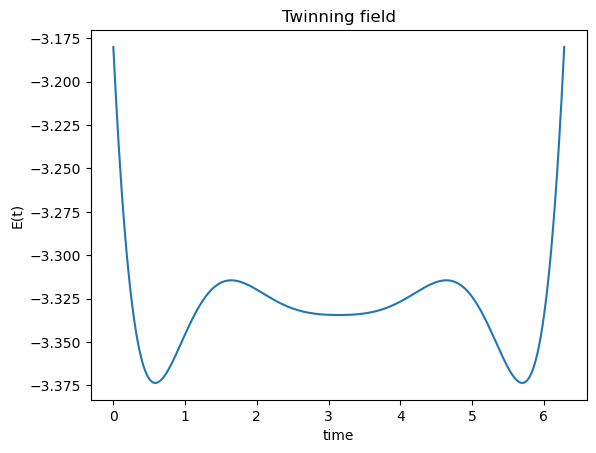

In [12]:
title("Twinning field")
plot(times, [E(t, twinning_X) for t in times], label="Twinning field")
xlabel("time")
ylabel("E(t)")

show()

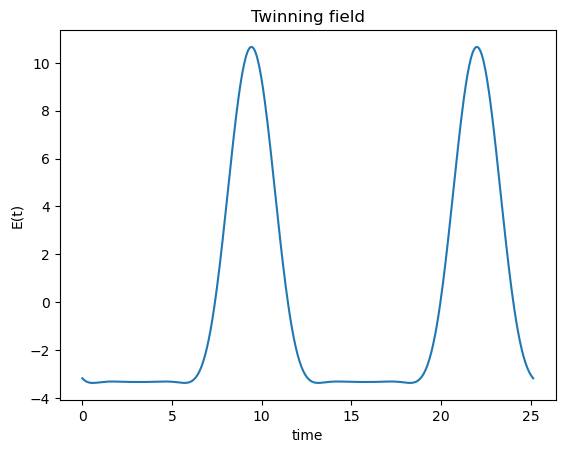

In [13]:

longer_times = 4 * times

title("Twinning field")
plot(longer_times, [E(t, twinning_X) for t in longer_times], label="Twinning field")
xlabel("time")
ylabel("E(t)")

show()

## Comparing dynamics for a given initial state

In [14]:
U₁(t, X) = exp(-im * Δt * Matrix(H₀₁ + E(t, X) * V₁))

ψ₀ = [1; 0]

Ψ₁ = zeros(Complex, length(times), length(ψ₀))
Ψ₁[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ₁[k, :] = U₁(Δt * (k - 2) + Δt / 2, twinning_X) * Ψ₁[k - 1, :]
end

#######################
U₂(t, X) = exp(-im * Δt * Matrix(H₀₂ + E(t, X) * V₂))
    
Ψ₂ = zeros(Complex, length(times), length(ψ₀))
Ψ₂[1, :] = ψ₀ 

for k in 2:length(times)
     Ψ₂[k, :] = U₂(Δt * (k - 2) + Δt / 2, twinning_X) * Ψ₂[k - 1, :]
end

In [15]:
nz₁ = real.([Ψ₁[k, :]' * σz * Ψ₁[k, :] for k in 1:length(times)])

nz₂ = real.([Ψ₂[k, :]' * σz * Ψ₂[k, :] for k in 1:length(times)]);

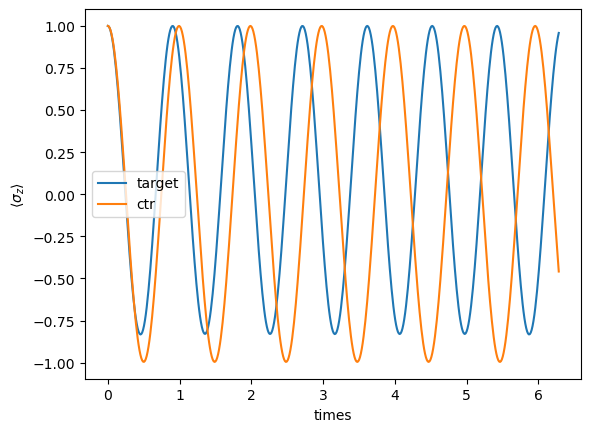

In [16]:
plot(times, nz₁, label="target")
plot(times, nz₂, label="ctr")
xlabel("times")
ylabel(L"\langle \sigma_z \rangle")
legend()
show()